In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import numpy as np 
import pandas as pd
import os
import shutil
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import Xception
import xml.etree.ElementTree as ET

In [3]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import albumentations as albu
from tqdm.notebook import tqdm

In [4]:
XML_PATH = os.path.join( "annotations/")
IMG_PATH = os.path.join( "path/")
XML_FILES = [os.path.join(XML_PATH, f) for f in os.listdir(XML_PATH)]

In [5]:
class XmlParser(object):

    def __init__(self,xml_file):

        self.xml_file = xml_file
        self._root = ET.parse(self.xml_file).getroot()
        self._objects = self._root.findall("object")
        # path to the image file as describe in the xml file
        self.img_path = os.path.join(IMG_PATH, self._root.find('filename').text)
        # image id 
        self.image_id = self._root.find("filename").text
        # names of the classes contained in the xml file
        self.names = self._get_names()
        # coordinates of the bounding boxes
        self.boxes = self._get_bndbox()

    def parse_xml(self):
        """"Parse the xml file returning the root."""
    
        tree = ET.parse(self.xml_file)
        return tree.getroot()

    def _get_names(self):

        names = []
        for obj in self._objects:
            name = obj.find("name")
            names.append(name.text)

        return np.array(names)

    def _get_bndbox(self):

        boxes = []
        for obj in self._objects:
            coordinates = []
            bndbox = obj.find("bndbox")
            coordinates.append(np.int32(bndbox.find("xmin").text))
            coordinates.append(np.int32(bndbox.find("ymin").text))
            coordinates.append(np.int32(bndbox.find("xmax").text))
            coordinates.append(np.int32(bndbox.find("ymax").text))
            boxes.append(coordinates)

        return np.array(boxes)



In [6]:
def xml_files_to_df(xml_files):   
    names = []
    boxes = []
    image_id = []
    xml_path = []
    img_path = []
    xmin=[]
    ymin=[]
    xmax=[]
    ymax=[]
    for file in xml_files:
        xml = XmlParser(file)
        names.extend(xml.names)
        boxes.extend(xml.boxes)
        
        image_id.extend([xml.image_id] * len(xml.names))
        xml_path.extend([xml.xml_file] * len(xml.names))
        img_path.extend([xml.img_path] * len(xml.names))
    a = {"image_id": image_id,
         
         "boxes": boxes,
         "names": names,
         }
    
    df = pd.DataFrame.from_dict(a, orient='index')
    df = df.transpose()
    
    return df

df = xml_files_to_df(XML_FILES)
df.head()

,image_id,boxes,names
0,new_data0.jpeg,"[448, 115, 751, 238]",rouille
1,new_data0.jpeg,"[478, 663, 568, 834]",rouille
2,new_data0.jpeg,"[662, 717, 841, 1002]",rouille
3,new_data0.jpeg,"[528, 776, 636, 1125]",rouille
4,new_data0.jpeg,"[52, 517, 420, 635]",rouille


In [7]:
for i in range(df.shape[0]):
    df.boxes[i][0]=df.boxes[i][0]
    df.boxes[i][1]=df.boxes[i][1]
    df.boxes[i][2]=(df.boxes[i][2]-df.boxes[i][0])
    df.boxes[i][3]=(df.boxes[i][3]-df.boxes[i][1])
    
    df.boxes[i][0]=df.boxes[i][0]/3.2
    df.boxes[i][1]=df.boxes[i][1]/4.2
    df.boxes[i][2]=df.boxes[i][2]/3.2
    df.boxes[i][3]=df.boxes[i][3]/4.2

In [8]:
df.head(50)

,image_id,boxes,names
0,new_data0.jpeg,"[140, 27, 94, 29]",rouille
1,new_data0.jpeg,"[149, 157, 28, 40]",rouille
2,new_data0.jpeg,"[206, 170, 55, 67]",rouille
3,new_data0.jpeg,"[165, 184, 33, 83]",rouille
4,new_data0.jpeg,"[16, 123, 115, 28]",rouille
5,new_data0.jpeg,"[244, 126, 54, 25]",rouille
6,new_data1.jpeg,"[39, 23, 140, 70]",rouille
7,new_data1.jpeg,"[97, 60, 193, 56]",rouille
8,new_data1.jpeg,"[64, 112, 147, 93]",rouille
9,new_data1.jpeg,"[27, 186, 147, 117]",rouille


In [9]:
df.shape

(2464, 3)

In [10]:
def group_boxes(group):
    boundaries = group['boxes']
    return boundaries.values

data = df.groupby('image_id').apply(group_boxes)

In [11]:
train_image_ids = np.unique(data.index.values)[0:494]
val_image_ids = np.unique(data.index.values)[494:617]

In [12]:
train_image_ids

array(['new_data0.jpeg', 'new_data1.jpeg', 'new_data10.jpeg',
       'new_data100.jpeg', 'new_data101.jpeg', 'new_data102.jpeg',
       'new_data103.jpeg', 'new_data104.jpeg', 'new_data105.jpeg',
       'new_data106.jpeg', 'new_data107.jpeg', 'new_data108.jpeg',
       'new_data109.jpeg', 'new_data11.jpeg', 'new_data110.jpeg',
       'new_data111.jpeg', 'new_data112.jpeg', 'new_data113.jpeg',
       'new_data114.jpeg', 'new_data115.jpeg', 'new_data116.jpeg',
       'new_data117.jpeg', 'new_data118.jpeg', 'new_data119.jpeg',
       'new_data12.jpeg', 'new_data120.jpeg', 'new_data121.jpeg',
       'new_data122.jpeg', 'new_data123.jpeg', 'new_data124.jpeg',
       'new_data125.jpeg', 'new_data126.jpeg', 'new_data127.jpeg',
       'new_data128.jpeg', 'new_data129.jpeg', 'new_data13.jpeg',
       'new_data130.jpeg', 'new_data131.jpeg', 'new_data132.jpeg',
       'new_data133.jpeg', 'new_data134.jpeg', 'new_data135.jpeg',
       'new_data136.jpeg', 'new_data137.jpeg', 'new_data138.jpeg',
   

In [13]:
data['new_data0.jpeg']

array([array([140,  27,  94,  29]), array([149, 157,  28,  40]),
       array([206, 170,  55,  67]), array([165, 184,  33,  83]),
       array([ 16, 123, 115,  28]), array([244, 126,  54,  25])],
      dtype=object)

In [14]:
def load_image(image_id):
    image = Image.open(IMG_PATH + image_id)
    width, height = image.size

    image = image.resize((300, 300))
        
           
    return np.asarray(image)

In [15]:
train_pixels = {}
train_labels = {}

for image_id in tqdm(train_image_ids):
    train_pixels[image_id] = load_image(image_id)
    train_labels[image_id] = data[image_id].copy()


  0%|          | 0/494 [00:00<?, ?it/s]

In [16]:
val_pixels = {}
val_labels = {}

for image_id in tqdm(val_image_ids):
    val_pixels[image_id] = load_image(image_id)    
    val_labels[image_id] = data[image_id].copy()

  0%|          | 0/123 [00:00<?, ?it/s]

In [17]:
train_labels['new_data0.jpeg']

array([array([140,  27,  94,  29]), array([149, 157,  28,  40]),
       array([206, 170,  55,  67]), array([165, 184,  33,  83]),
       array([ 16, 123, 115,  28]), array([244, 126,  54,  25])],
      dtype=object)

In [18]:
def draw_bboxes(image_id, bboxes ):  
    image = Image.open(IMG_PATH+ image_id)
    image = image.resize((300, 300))
    draw = ImageDraw.Draw(image)
    for bbox in bboxes:
        draw_bbox(draw, bbox)
    return np.asarray(image)

def draw_bbox(draw, bbox):
    x, y, width, height = bbox
    draw.rectangle([x, y, x + width, y + height], width=2, outline='red')

In [19]:
def show_images(image_ids, bboxes):
    pixels = []
    
    for image_id in image_ids:
        pixels.append(
            draw_bboxes(image_id, bboxes[image_id])
        )
    
    num_of_images = len(image_ids)
    fig, axes = plt.subplots(
        1, 
        num_of_images, 
        figsize=(5 * num_of_images, 5* num_of_images)
    )
    
    for i, image_pixels in enumerate(pixels):
        axes[i].imshow(image_pixels)

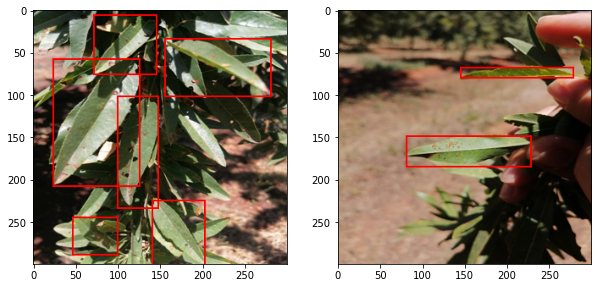

In [20]:
show_images(train_image_ids[123:125], train_labels)

In [21]:
tiny_bboxes = []

for i, image_id in enumerate(train_image_ids):
    for label in train_labels[image_id]:
        if label[2] * label[3] <= 10 and label[2] * label[3] != 0:
            tiny_bboxes.append(i)

            
print(str(len(tiny_bboxes)) + ' tiny bounding boxes found')

0 tiny bounding boxes found


In [22]:
huge_bboxes = []

for i, image_id in enumerate(train_image_ids):
    for label in train_labels[image_id]:
        if label[2] * label[3] > 8000:
            huge_bboxes.append(i)

            
print(str(len(huge_bboxes)) + ' huge bounding boxes found')

499 huge bounding boxes found


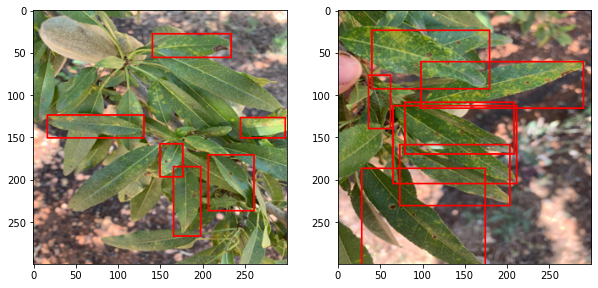

In [23]:
show_images(train_image_ids[0:2], train_labels)

In [24]:
def clean_labels(train_image_ids, train_labels):
    good_labels = {}
    
    for i, image_id in enumerate(train_image_ids):
        good_labels[image_id] = []
        
        for j, label in enumerate(train_labels[image_id]):

            # remove huge bbox
            if label[2] * label[3] > 8000 and i not in [1079, 1371, 2020]:
                continue

            # remove tiny bbox
            elif label[2] < 5 or label[3] < 5:
                continue
                
            else:
                good_labels[image_id].append(
                    train_labels[image_id][j]
                )
                
    return good_labels

train_labels = clean_labels(train_image_ids, train_labels)

## data pipeline

In [25]:
!pip install -U albumentations --upgrade

You should consider upgrading via the 'C:\Users\zakaria\anaconda3\python.exe -m pip install --upgrade pip' command.


In [26]:


class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, image_ids, image_pixels, labels=None, batch_size=1, shuffle=False, augment=False):
        self.image_ids = image_ids
        self.image_pixels = image_pixels
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
        self.image_grid = self.form_image_grid()
        
        
    def form_image_grid(self):    
        image_grid = np.zeros((32, 32, 4))

        # x, y, width, height
        cell = [0, 0, 300 / 32, 300 / 32] 

        for i in range(0, 32):
            for j in range(0, 32):
                image_grid[i,j] = cell

                cell[0] = cell[0] + cell[2]

            cell[0] = 0
            cell[1] = cell[1] + cell[3]

        return image_grid
    

    def __len__(self):
        return int(np.floor(len(self.image_ids) / self.batch_size))


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_ids))

        if self.shuffle == True:
            np.random.shuffle(self.indexes)



In [27]:
DataGenerator.train_augmentations = albu.Compose([ 
    ], 
    )

DataGenerator.val_augmentations = albu.Compose([
    
])

In [28]:


def __getitem__(self, index):
    indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

    batch_ids = [self.image_ids[i] for i in indexes]

    X, y = self.__data_generation(batch_ids)

    return X, y

def __data_generation(self, batch_ids):
    X= np.empty((self.batch_size,300,300, 3))
    y = []

    # Generate data
    for i, image_id in enumerate(batch_ids):
        pixels = self.image_pixels[image_id]
        bboxes = self.labels[image_id]

        if self.augment:     
            pixels, bboxes = self.augment_image(pixels, bboxes)
        else:
            pixels = self.contrast_image(pixels)
            bboxes = self.form_label_grid(bboxes)

        X[i]=pixels
        y.append(bboxes)

    return X, np.array(y)


def augment_image(self, pixels, bboxes):
    bbox_labels = np.ones(len(bboxes))

    aug_result = self.train_augmentations(image=pixels, bboxes=bboxes, labels=bbox_labels)

    bboxes = self.form_label_grid(aug_result['bboxes'])

    return np.array(aug_result['image']) / 255, bboxes


def contrast_image(self, pixels):        
    aug_result = self.val_augmentations(image=pixels)
    return np.array(aug_result['image']) / 255


DataGenerator.__getitem__ = __getitem__
DataGenerator.__data_generation = __data_generation
DataGenerator.augment_image = augment_image
DataGenerator.contrast_image = contrast_image

In [59]:
def form_label_grid(self, bboxes):
    label_grid = np.zeros((32, 32, 10))

    for i in range(0, 32):
        for j in range(0, 32):
            cell = self.image_grid[i,j]
            label_grid[i,j] = self.rect_intersect(cell, bboxes)

    return label_grid


def rect_intersect(self, cell, bboxes): 
    cell_x, cell_y, cell_width, cell_height = cell
    cell_x_max = cell_x + cell_width 
    cell_y_max = cell_y + cell_height
    
    anchor_one = np.array([0, 0, 0, 0, 0])
    anchor_two = np.array([0, 0, 0, 0, 0])

    # check all boxes
    for bbox in bboxes:
        box_x, box_y, box_width, box_height = bbox
        
        box_x_centre = box_x + (box_width / 2)
        box_y_centre = box_y + (box_height / 2)

        if(box_x_centre >= cell_x and box_x_centre < cell_x_max and box_y_centre >= cell_y and box_y_centre < cell_y_max):

            if anchor_one[0] == 0:
                anchor_one = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )

            if anchor_one[0] != 0 and anchor_two[0] == 0:
                anchor_two = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )

            if anchor_one[0] != 0 and anchor_two[0] != 0:
                break
        
    return np.concatenate((anchor_one, anchor_two), axis=None)


def yolo_shape(self, box, cell):
    box_x, box_y, box_width, box_height = box
    cell_x, cell_y, cell_width, cell_height = cell

    # top left x,y to centre x,y
    box_x = box_x + (box_width / 2)
    box_y = box_y + (box_height / 2)

    # offset bbox x,y to cell x,y
    box_x = (box_x - cell_x) / cell_width
    box_y = (box_y - cell_y) / cell_height

    # bbox width,height relative to cell width,height
    box_width = box_width / 300
    box_height = box_height / 300

    return [1, box_x, box_y, box_width, box_height]


DataGenerator.form_label_grid = form_label_grid
DataGenerator.rect_intersect = rect_intersect
DataGenerator.yolo_shape = yolo_shape

In [158]:
train_generator = DataGenerator(
    train_image_ids,
    train_pixels,
    train_labels, 
    batch_size=10, 
    shuffle=True,
    augment=True
)

val_generator = DataGenerator(
    val_image_ids, 
    val_pixels,
    val_labels, 
    batch_size=10,
    shuffle=False,
    augment=False
)

image_grid = train_generator.image_grid

In [159]:
x_input = tf.keras.Input(shape=(300,300,3))

x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

########## block 1 ##########
x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x


########## block 2 ##########
x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 3 ##########
x = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

    
########## block 4 ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 5 ##########
x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(4):
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## output layers ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

predictions = tf.keras.layers.Conv2D(10, (1, 1), strides=(1, 1), activation='sigmoid')(x)

model = tf.keras.Model(inputs=x_input, outputs=predictions)

In [160]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1159 (Conv2D)            (None, 300, 300, 32) 896         input_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1140 (Batch (None, 300, 300, 32) 128         conv2d_1159[0][0]                
__________________________________________________________________________________________________
leaky_re_lu_1620 (LeakyReLU)    (None, 300, 300, 32) 0           batch_normalization_1140[0][0]   
___________________________________________________________________________________________

In [165]:
def custom_loss(y_true, y_pred):
    binary_crossentropy  = tf.keras.losses.BinaryCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    
    prob_loss = binary_crossentropy(
        tf.concat([y_true[:,:,:,0], y_true[:,:,:,5]], axis=0), 
        tf.concat([y_pred[:,:,:,0], y_pred[:,:,:,5]], axis=0)
    )
    
    xy_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,1:3], y_true[:,:,:,6:8]], axis=0), 
        tf.concat([y_pred[:,:,:,1:3], y_pred[:,:,:,6:8]], axis=0)
    )
    
    wh_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,3:5], y_true[:,:,:,8:10]], axis=0), 
        tf.concat([y_pred[:,:,:,3:5], y_pred[:,:,:,8:10]], axis=0)
    )
    
    bboxes_mask = get_mask(y_true)
    
    xy_loss = xy_loss * bboxes_mask
    wh_loss = wh_loss * bboxes_mask
    
    return prob_loss + xy_loss + wh_loss


def get_mask(y_true):
    anchor_one_mask = tf.where(
        y_true[:,:,:,0] == 0, 
        0.5, 
        5.0
    )
    
    anchor_two_mask = tf.where(
        y_true[:,:,:,5] == 0, 
        0.5, 
        5.0
    )
    
    bboxes_mask = tf.concat(
        [anchor_one_mask,anchor_two_mask],
        axis=0
    )
    
    return bboxes_mask

In [166]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.00001)

model.compile(
    optimizer=optimiser, 
    loss=custom_loss,
    metrics=["accuracy"]
)

In [167]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True),
]

In [168]:
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    epochs=80,
    callbacks=callbacks
)

Epoch 1/80


ResourceExhaustedError:  OOM when allocating tensor with shape[10,64,300,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_18/conv2d_1166/Conv2D (defined at <ipython-input-168-0355dec987c0>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_273904]

Function call stack:
train_function
